# Climbing image NEB example - Lammps

In [1]:
# headers

# general modules
import numpy as np
import matplotlib.pyplot as plt

# pyiron modules
from pyiron_atomistics import Project
import pyiron_contrib

In [2]:
# define project

pr = Project('neb_example')
pr.remove_jobs(recursive=True)

In [3]:
# check the git head of the repos that this notebook worked on when this notebook was written

pr.get_repository_status()

,Module,Git head
0,pyiron,1b8bc7ff9ead77daf3e0e65ded2eb22e16ac4b69
1,pyiron_mpie,d90b955fb16fefd70ccab9d69c7c177190c81fd7
2,pyiron_contrib,4c8aab96daa8bbbbb3daea4ebd763d5eaf91082b
3,pyiron_base,4f22b9f2f32294d4f9f6f45f1e53b275239d0aed


In [4]:
# inputs 

# structure specific
element = 'Al'
supercell = 3
vac_id_initial = 0
vac_id_final = 1
cubic = True

# job specific
potential = '2008--Mendelev-M-I--Al--LAMMPS--ipr1'

# NEB specific
n_images = 9
neb_steps = 200
gamma0 = 0.01
climbing_image = True

In [5]:
# create base structure

box = pr.create_ase_bulk(name=element, cubic=cubic).repeat(supercell)

In [6]:
# template minimization job

template_job = pr.create_job(job_type=pr.job_type.Lammps, job_name='template')
template_job.potential = potential

In [7]:
# vacancy @ atom id 0 minimization

vac_0_struct = box.copy()  # copy box
vac_0_struct.pop(vac_id_initial)  # create vacancy

vac_0 = template_job.copy_template(project=pr, new_job_name='vac_0')
vac_0.structure = vac_0_struct
vac_0.calc_minimize(pressure=0.)
vac_0.run()

# vacancy @ atom id 1 minimization

vac_1_struct = box.copy()  # copy box
vac_1_struct.pop(vac_id_final)  # create vacancy

vac_1 = template_job.copy_template(project=pr, new_job_name='vac_1')
vac_1.structure = vac_1_struct
vac_1.calc_minimize(pressure=0.)
vac_1.run()

The job vac_0 was saved and received the ID: 10136528
The job vac_1 was saved and received the ID: 10136529


In [8]:
# create and run the NEB job

pr_neb = pr.create_group('neb')  # create a new folder

neb_ref = pr_neb.create_job(job_type=pr.job_type.Lammps, job_name='ref_neb')
neb_ref.structure = vac_0.get_structure()
neb_ref.potential = potential
neb_ref.save()  # Don't forget this step!

neb_job = pr_neb.create_job(job_type=pr.job_type.ProtoNEBSer, job_name='neb_job')
neb_job.input.ref_job_full_path = neb_ref.path
neb_job.input.structure_initial = vac_0.get_structure()
neb_job.input.structure_final = vac_1.get_structure()
neb_job.input.n_images = n_images
neb_job.input.n_steps = neb_steps
neb_job.input.gamma0 = gamma0
neb_job.input.use_climbing_image = climbing_image

# set_output_whitelist sets how often an output of a particular vertex is stored in the archive.
# for example, here, the output 'energy_pot' of vertex 'calc_static' is saved every 20 steps in the archive.
neb_job.set_output_whitelist(**{'calc_static': {'energy_pot': 20}})

neb_job.run()

The job ref_neb was saved and received the ID: 10136530
The job neb_job was saved and received the ID: 10136531
The job neb_job_initialize_jobs_0 was saved and received the ID: 10136532
The job neb_job_initialize_jobs_1 was saved and received the ID: 10136533
The job neb_job_initialize_jobs_2 was saved and received the ID: 10136534
The job neb_job_initialize_jobs_3 was saved and received the ID: 10136535
The job neb_job_initialize_jobs_4 was saved and received the ID: 10136536
The job neb_job_initialize_jobs_5 was saved and received the ID: 10136537
The job neb_job_initialize_jobs_6 was saved and received the ID: 10136538
The job neb_job_initialize_jobs_7 was saved and received the ID: 10136539
The job neb_job_initialize_jobs_8 was saved and received the ID: 10136540


/u/rads/pyiron_repos/pyiron_base/pyiron_base/generic/parameters.py:284: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  "The input in GenericParameters changed, while the state of the job was already finished."


In [9]:
# lets check the archive for the output - 1

neb_job['graph/vertices/calc_static/archive/output/energy_pot']
# here we see in 'nodes' that the output is stored every 20 steps
# note: unfortunately, this is the only way to access the archive quantitites at the moment!
# note: all outputs of the other nodes will only be saved for the final step!

{'groups': [], 'nodes': ['FULLNAME', 'TYPE', 't_0', 't_100', 't_120', 't_140', 't_160', 't_180', 't_20', 't_40', 't_60', 't_80']}

In [10]:
# lets check the archive for the output - 2

# the final image energies?
neb_job['graph/vertices/calc_static/archive/output/energy_pot/t_80']

array([-364.28366497, -364.17408894, -363.90675179, -363.70742462,
       -363.62194441, -363.70742462, -363.90675179, -364.17408894,
       -364.28366497])

<AxesSubplot:xlabel='Image', ylabel='Energy'>

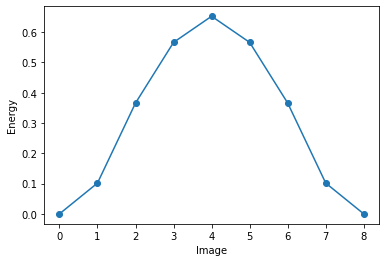

In [11]:
# lets plot the final barrier

neb_job.plot_elastic_band(frame=-1)

In [12]:
# lets get the migration barrier over different archived iterations

e_mig = [neb_job.get_barrier(frame=i) for i in range(int(neb_steps/20))]

# final migration barrier after 200 steps
print('final migration barrier = {}'.format(e_mig[-1]))

final migration barrier = 0.6524359464470422


Notes: At the moment, there is no convergence criterion implemented for this NEB protocol. So it runs for all of the steps that have been provided as an input.

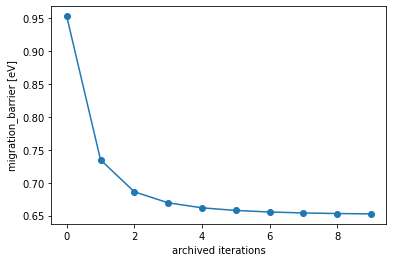

In [13]:
# plot the iterations

plt.plot(e_mig, marker='o')
plt.xlabel('archived iterations')
plt.ylabel('migration_barrier [eV]')
plt.show()

In [14]:
# other output saved by the job can be obtained only for the final step!

neb_job.output.keys()

dict_keys(['energy_pot', 'positions', 'forces'])